# Report 1 Group 93

Here is the code we developed for the Intro to Machine Learning report.

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
try:
    from ucimlrepo import fetch_ucirepo
except ImportError:
    print("Please install the ucimlrepo with pip :)")

## Initial setup

First we fetch the data from ucirepo, and then do some basic analysis of the data.

In [3]:
# fetch dataset 
cirrhosis_patient_survival_prediction = fetch_ucirepo(id=878) 
  
# data (as pandas dataframes) 
X = cirrhosis_patient_survival_prediction.data.features 
  
# metadata 
print(cirrhosis_patient_survival_prediction.metadata) 
  
# variable information 
print(cirrhosis_patient_survival_prediction.variables)

data = pd.DataFrame(X)

{'uci_id': 878, 'name': 'Cirrhosis Patient Survival Prediction', 'repository_url': 'https://archive.ics.uci.edu/dataset/878/cirrhosis+patient+survival+prediction+dataset-1', 'data_url': 'https://archive.ics.uci.edu/static/public/878/data.csv', 'abstract': 'Utilize 17 clinical features for predicting survival state of patients with liver cirrhosis. The survival states include 0 = D (death), 1 = C (censored), 2 = CL (censored due to liver transplantation).', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 418, 'num_features': 17, 'feature_types': ['Real', 'Categorical'], 'demographics': ['Age', 'Sex'], 'target_col': ['Status'], 'index_col': ['ID'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5R02G', 'creators': ['E. Dickson', 'P. Grambsch', 'T. Fleming', 'L. Fisher', 'A. Langworthy'], 'intro_paper': {'ID': 296, 'type'

In [4]:
print(data.head())

              Drug    Age Sex Ascites Hepatomegaly Spiders Edema  Bilirubin  \
0  D-penicillamine  21464   F       Y            Y       Y     Y       14.5   
1  D-penicillamine  20617   F       N            Y       Y     N        1.1   
2  D-penicillamine  25594   M       N            N       N     S        1.4   
3  D-penicillamine  19994   F       N            Y       Y     S        1.8   
4          Placebo  13918   F       N            Y       Y     N        3.4   

  Cholesterol  Albumin Copper  Alk_Phos    SGOT Tryglicerides Platelets  \
0         261     2.60    156    1718.0  137.95           172       190   
1         302     4.14     54    7394.8  113.52            88       221   
2         176     3.48    210     516.0   96.10            55       151   
3         244     2.54     64    6121.8   60.63            92       183   
4         279     3.53    143     671.0  113.15            72       136   

   Prothrombin  Stage  
0         12.2    4.0  
1         10.6    3.0  
2 

In [5]:
print(data.describe())

                Age   Bilirubin     Albumin      Alk_Phos        SGOT  \
count    418.000000  418.000000  418.000000    312.000000  312.000000   
mean   18533.351675    3.220813    3.497440   1982.655769  122.556346   
std     3815.845055    4.407506    0.424972   2140.388824   56.699525   
min     9598.000000    0.300000    1.960000    289.000000   26.350000   
25%    15644.500000    0.800000    3.242500    871.500000   80.600000   
50%    18628.000000    1.400000    3.530000   1259.000000  114.700000   
75%    21272.500000    3.400000    3.770000   1980.000000  151.900000   
max    28650.000000   28.000000    4.640000  13862.400000  457.250000   

       Prothrombin       Stage  
count   416.000000  412.000000  
mean     10.731731    3.024272  
std       1.022000    0.882042  
min       9.000000    1.000000  
25%      10.000000    2.000000  
50%      10.600000    3.000000  
75%      11.100000    4.000000  
max      18.000000    4.000000  


We realized there are some variables where the values are saved as strings and some of them had the value "NaNN", indicating a missing value, but not being detected as a nan. Here we count the number of missing values per variable.

In [6]:
#data preparation and cleaning

data = data.replace('NaNN', np.nan)

cols = data.columns

na_per_col = {}

for col in cols:
    na_per_col[col] = data[col].isna().sum()


for key, value in na_per_col.items():
    print(key, value)

Drug 106
Age 0
Sex 0
Ascites 106
Hepatomegaly 106
Spiders 106
Edema 0
Bilirubin 0
Cholesterol 134
Albumin 0
Copper 108
Alk_Phos 106
SGOT 106
Tryglicerides 136
Platelets 11
Prothrombin 2
Stage 6


# PCA

Now we'll analyze PCA and plot different things. First, we will drop the binary/text variables and drop all the touples containing missing values.

In [7]:
data.drop(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], axis=1, inplace=True)

data = data.dropna()

data.describe()

,Age,Bilirubin,Albumin,Alk_Phos,SGOT,Prothrombin,Stage
count,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000
mean,18189.326087,3.333696,3.516812,1996.611594,124.119239,10.735507,3.039855
std,3843.555619,4.601074,0.404789,2115.477894,56.719952,1.008315,0.853999
min,9598.000000,0.300000,1.960000,289.000000,28.380000,9.000000,1.000000
25%,15162.500000,0.800000,3.310000,922.500000,82.457500,10.000000,2.000000
50%,18156.500000,1.400000,3.545000,1277.500000,116.625000,10.600000,3.000000
75%,20667.500000,3.525000,3.772500,2068.250000,153.450000,11.200000,4.000000
max,28650.000000,28.000000,4.400000,13862.400000,457.250000,17.100000,4.000000


Now, converting all strings to int

In [8]:
#convert all data to integers

ints = ['Age', 'Copper', 'Platelets', 'Cholesterol', 'Tryglicerides']

for i in ints:
    print(i)
    data[i] = list(map(int, data[i]))

Age
Copper
Platelets
Cholesterol
Tryglicerides


No we will fill a matrix with the values for easo of use for the PCA, plotting and transformations.

In [9]:
# Extract attribute names (1st row, column 4 to 12)
attributeNames = list(data.columns)

# Extract class names to python list
classLabels = sorted(set(data.Stage))
y = data.Stage

# Preallocate memory, then extract excel data to matrix X
X = np.empty((len(data), 10))
for i, col_id in enumerate(range(0,10)):
    X[:, i] = np.asarray(data.iloc[:, col_id])

# Compute values of N, M and C.
N = len(y)
M = len(attributeNames)
C = len(classLabels)

print(N, M, C)

276 11 4


### Distribution plotting

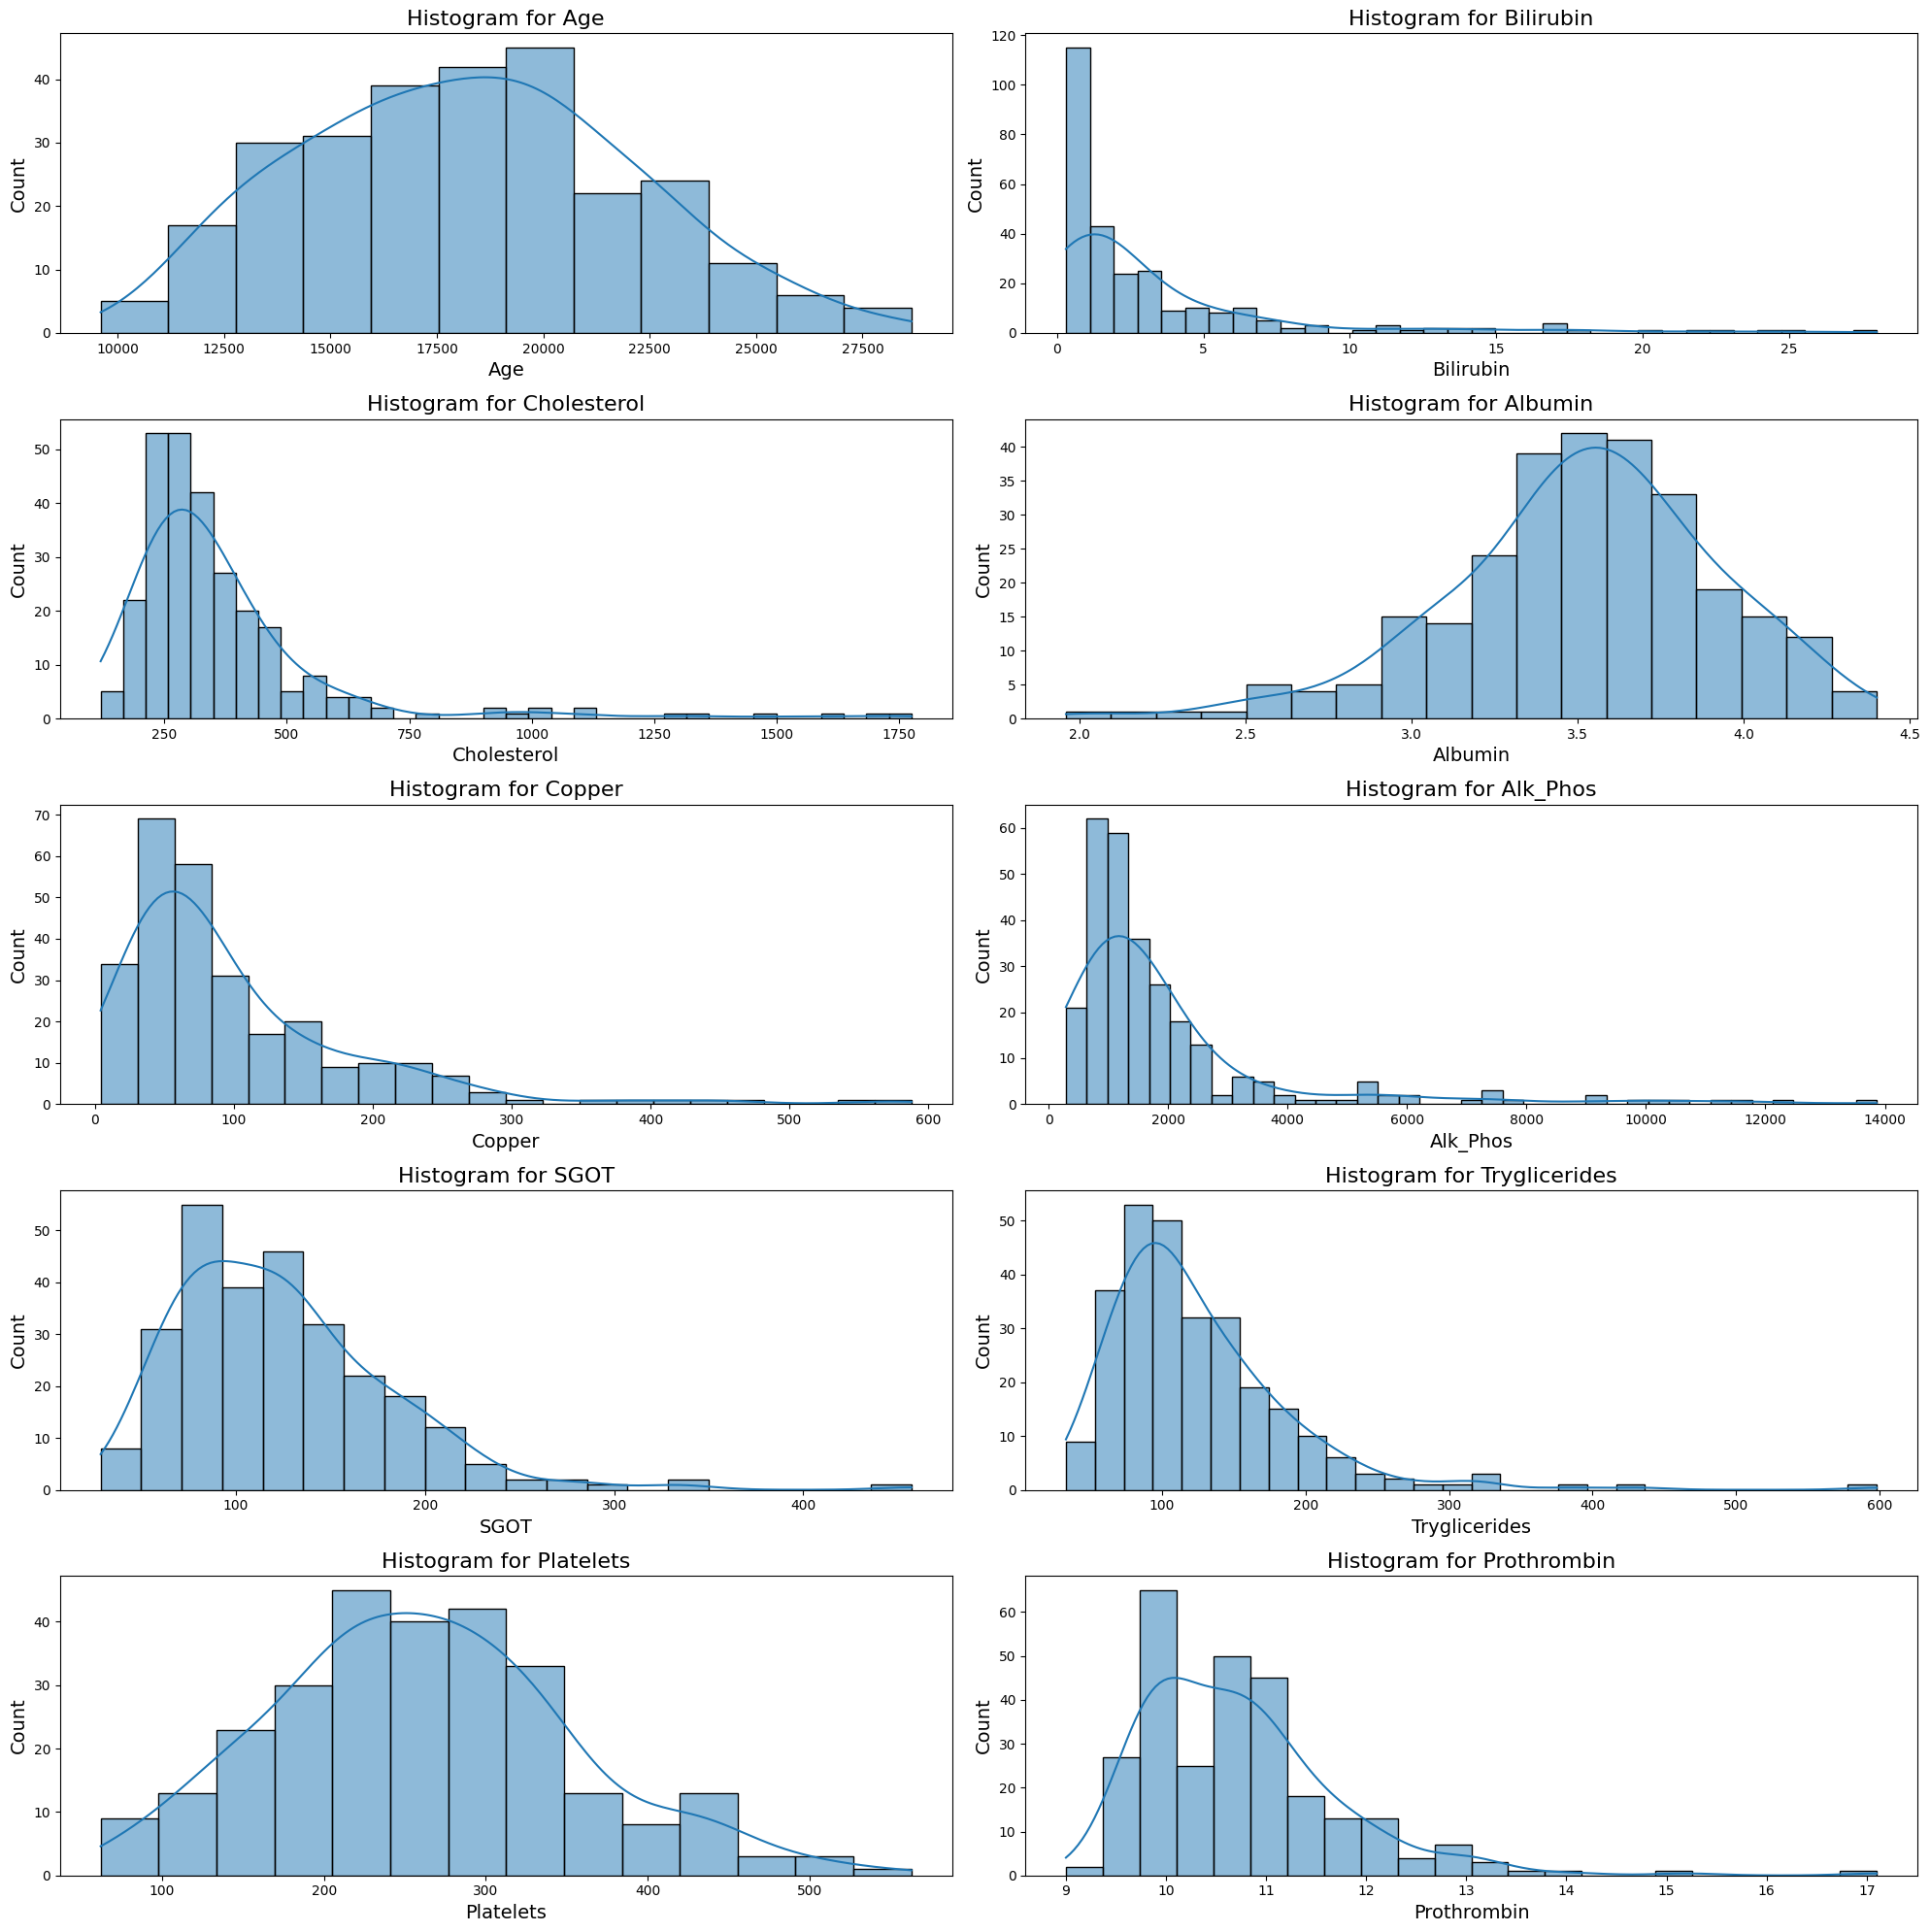

In [10]:
# Create a 4x4 grid of subplots
fig, axes = plt.subplots(5, 2, figsize=(20, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over each column in X
for i, col_name in enumerate(attributeNames[:-1]):
    # Plot continuous line for the distribution
    sns.histplot(X[:, i], ax=axes[i], kde=True)
    
    # Set title and labels
    axes[i].set_title(f'Histogram for {col_name}', fontsize=16)
    axes[i].set_xlabel(col_name, fontsize=14)
    axes[i].set_ylabel('Count', fontsize=14)

# Adjust layout
plt.tight_layout()

#plt.savefig('unscaled.svg')

# Show plot
plt.show()

We will transform the data by applying the log to the skewed variables and scaling all the data.

In [11]:
convert = ['Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Prothrombin', 'Cholesterol', 'Bilirubin']

# Convert the columns to log scale
for col in convert:
    data[col] = np.log(data[col])

# Preallocate memory, then extract excel data to matrix X
X = np.empty((len(data), 10))
for i, col_id in enumerate(range(0,10)):
    X[:, i] = np.asarray(data.iloc[:, col_id])

# Subtract mean value from data
Y = X - np.ones((N, 1)) * X.mean(0)

# scale the data in the range of [0, 1]
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
Y_scaled = scaler.fit_transform(Y)

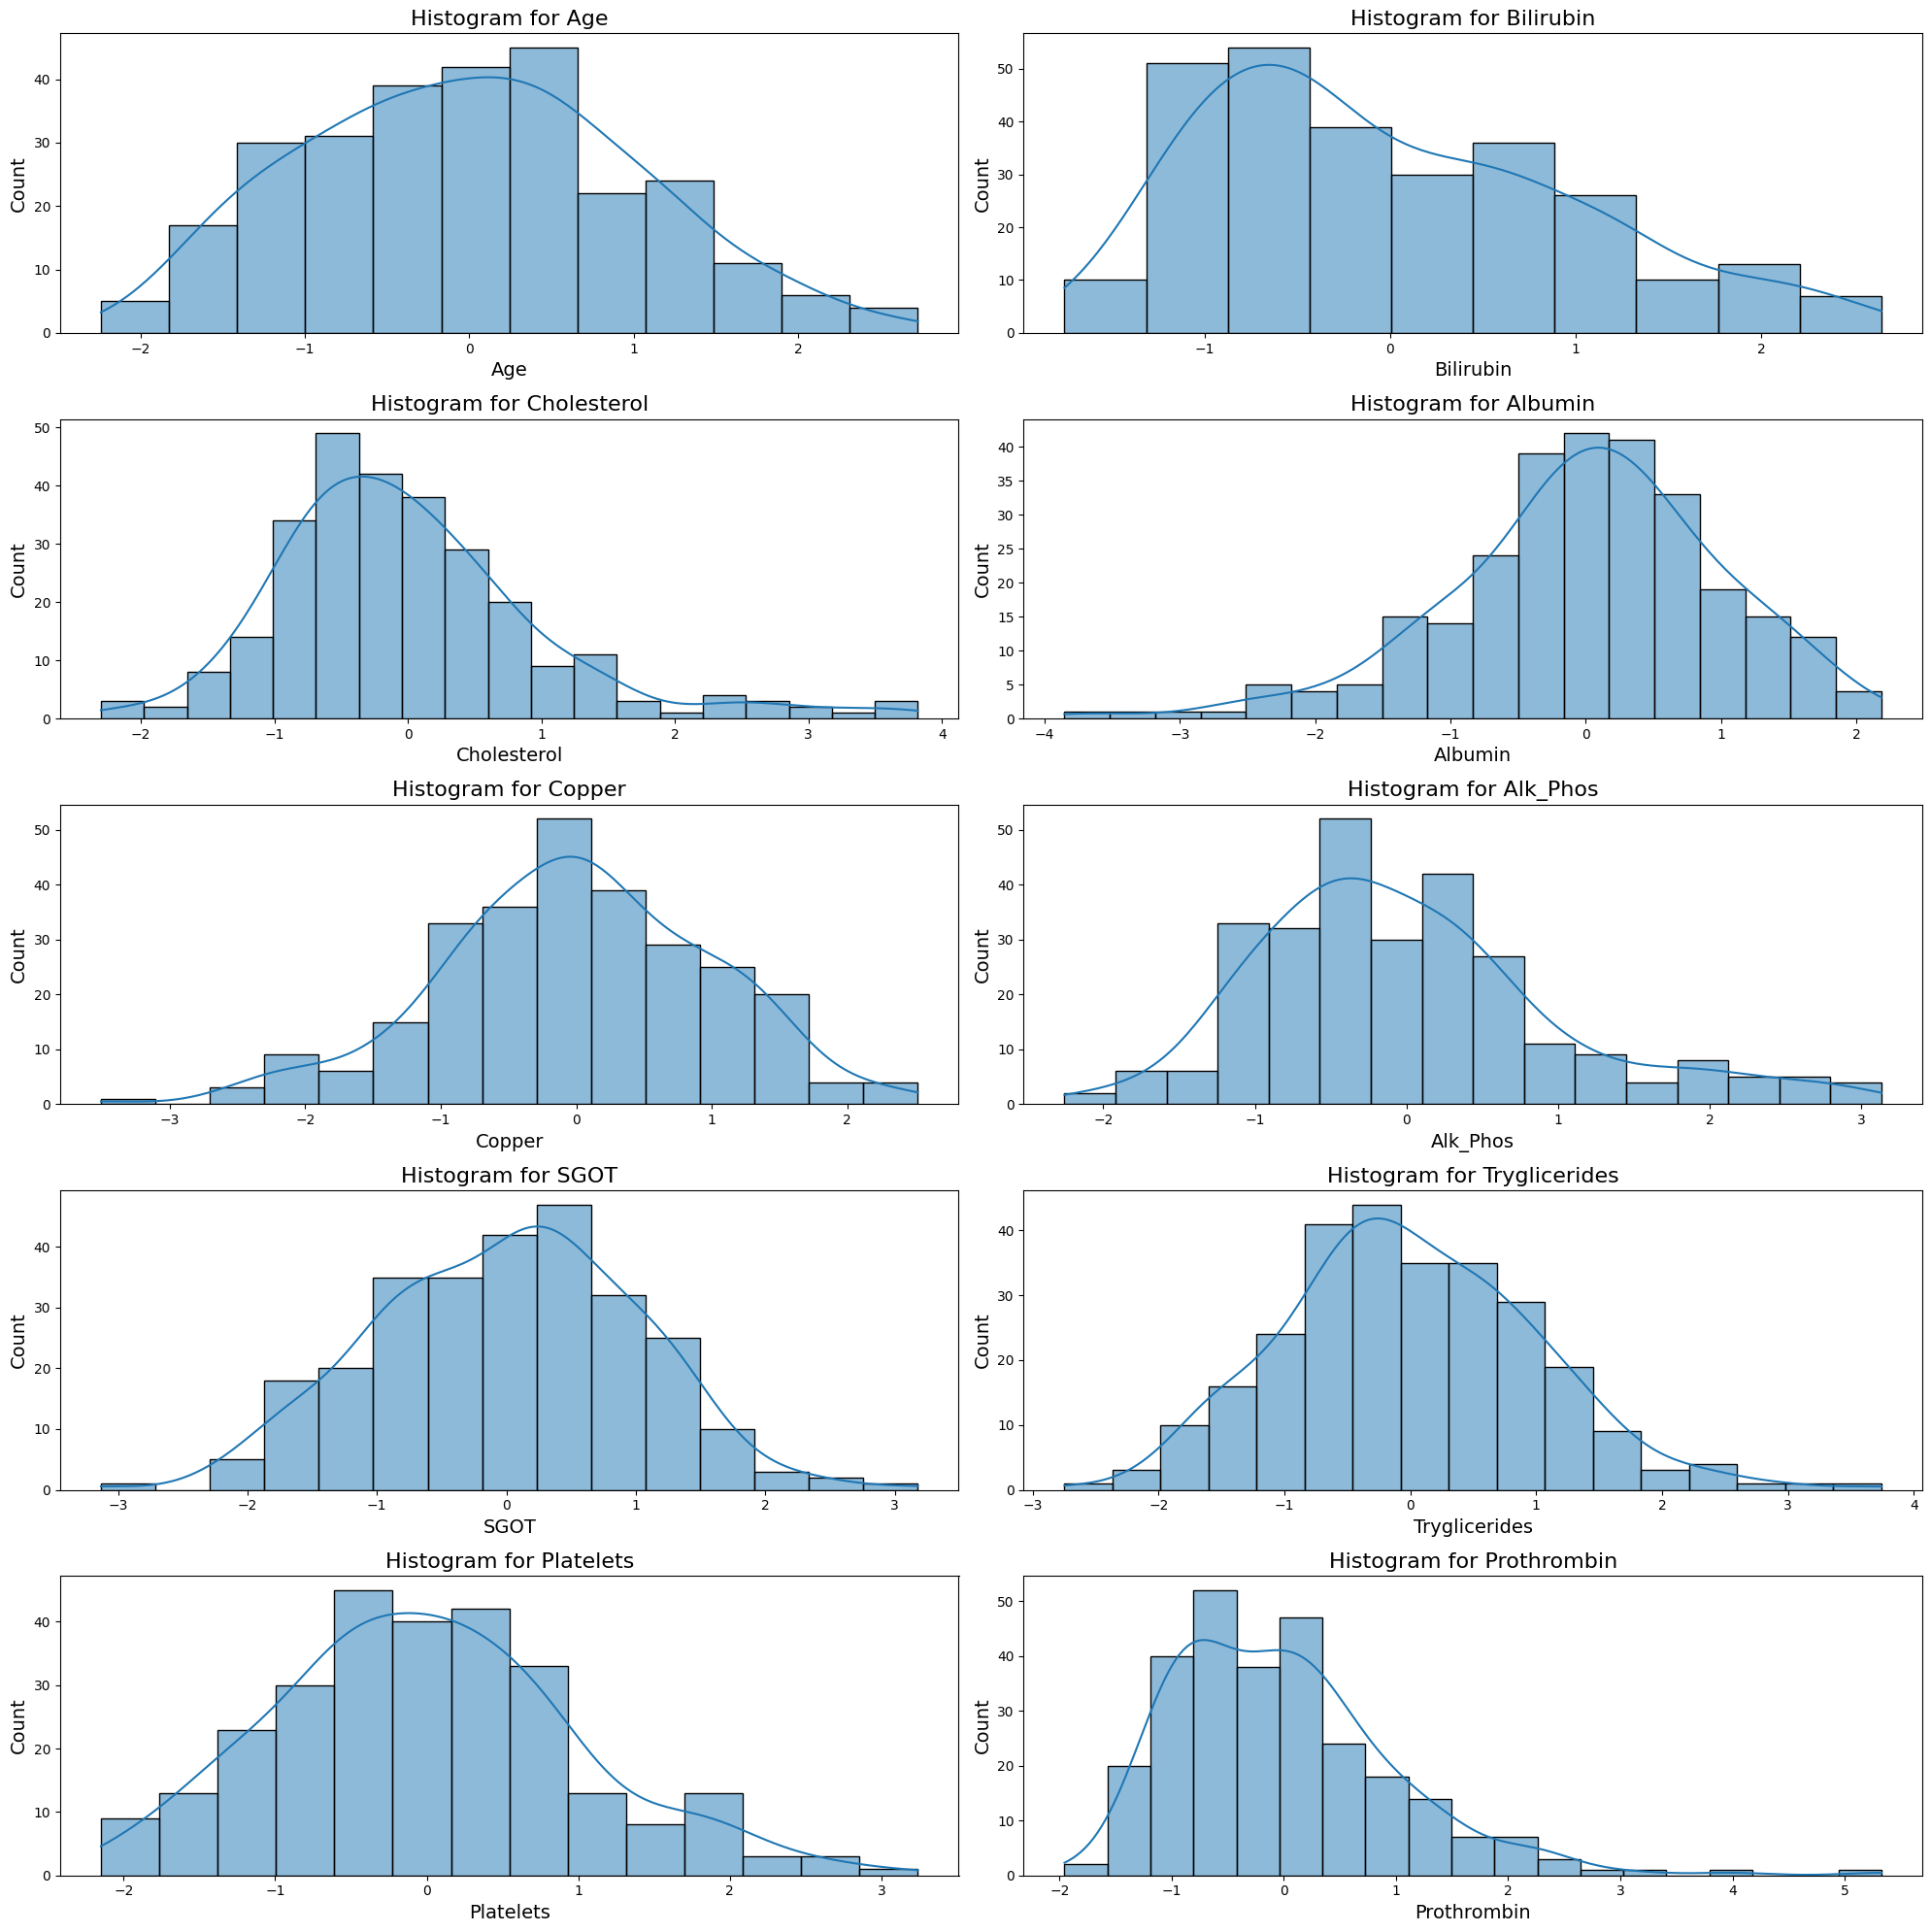

In [12]:
# Create a 4x4 grid of subplots
fig, axes = plt.subplots(5, 2, figsize=(20, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over each column in X
for i, col_name in enumerate(attributeNames[:-1]):
    # Plot continuous line for the distribution
    sns.histplot(Y_scaled[:, i], ax=axes[i], kde=True)
    
    # Set title and labels
    axes[i].set_title(f'Histogram for {col_name}', fontsize=16)
    axes[i].set_xlabel(col_name, fontsize=14)
    axes[i].set_ylabel('Count', fontsize=14)

# Adjust layout
plt.tight_layout()

#plt.savefig('scaled_corrected.svg')

# Show plot
plt.show()

### Correlation matrix

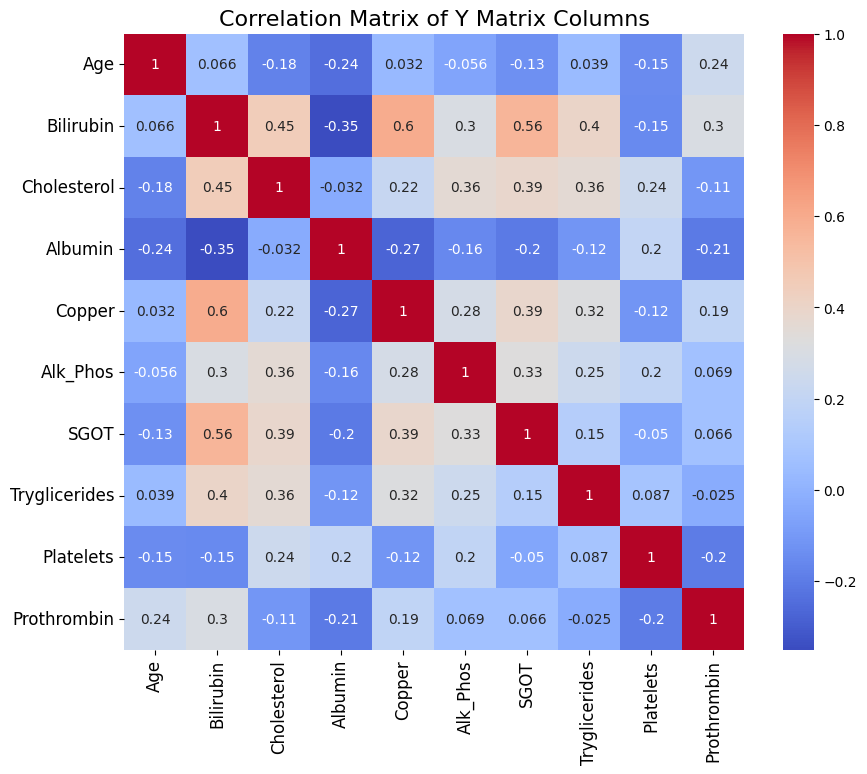

In [13]:
# Calculate the correlation matrix
correlation_matrix = np.corrcoef(Y_scaled.T)

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=attributeNames[:-1], yticklabels=attributeNames[:-1])
plt.title('Correlation Matrix of Y Matrix Columns', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


# Save the heatmap as a .svg file
#plt.savefig('correlation_matrix.svg')
plt.show()


### PCA variables

Now, we calculate the PCA values and plot the variance explained by every PC variable and the cumulative variance.

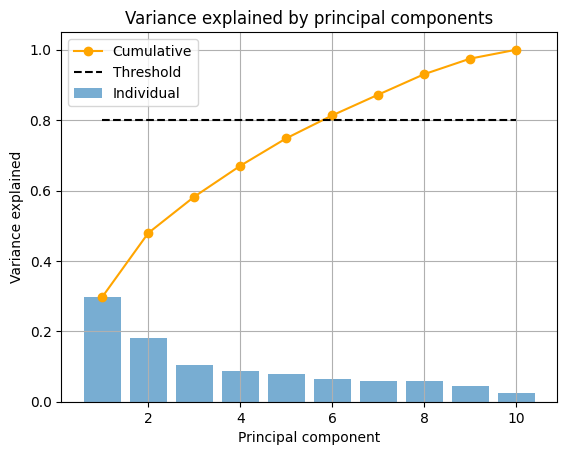

In [14]:
# PCA by computing SVD of Y
U, S, Vh = svd(Y_scaled, full_matrices=False)
# scipy.linalg.svd returns "Vh", which is the Hermitian (transpose)
# of the vector V. So, for us to obtain the correct V, we transpose:
V = Vh.T

# Project the centered data onto principal component space
Z = Y_scaled @ V

# Compute variance explained by principal components
rho = (S * S) / (S * S).sum()

threshold = 0.8

# Plot variance explained
plt.figure()
plt.bar(range(1, len(rho) + 1), rho, alpha=0.6, label="Individual")
plt.plot(range(1, len(rho) + 1), np.cumsum(rho), "o-", label="Cumulative", color="orange")
plt.plot([1, len(rho)], [threshold, threshold], "k--", label="Threshold")
plt.title("Variance explained by principal components")
plt.xlabel("Principal component")
plt.ylabel("Variance explained")
plt.legend()
plt.grid()

#plt.savefig('variance_explained.svg')
plt.show()

Now we show the first 6 Principal components and the effect of each variable on them

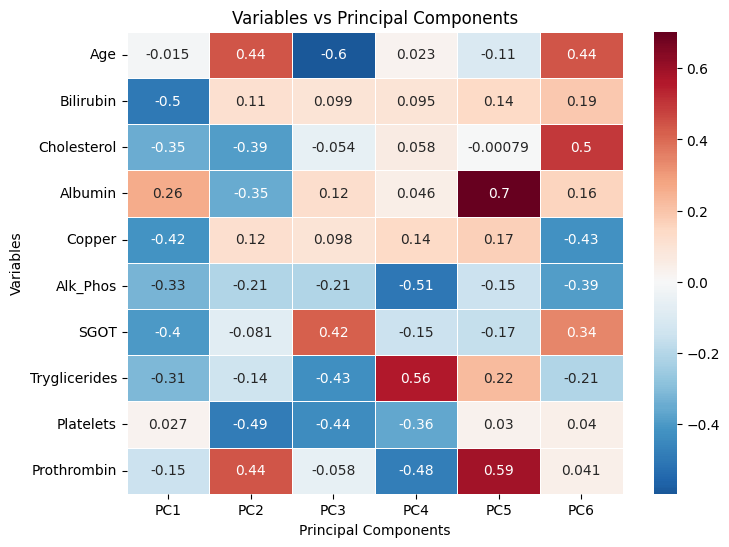

In [15]:


# Convert to DataFrame for easier handling
loading_df = pd.DataFrame(V[:,:6], index=data.columns[:-1], columns=[f'PC{i+1}' for i in range(6)])

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(V[:,:6], annot=True, cmap='RdBu_r', center=0, linewidths=0.5, xticklabels=loading_df.columns, yticklabels=loading_df.index)



# Add labels and title
plt.title('Variables vs Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Variables')

# Save the plot as a .svg file
#plt.savefig('variables-pca.svg')

# Display the plot
plt.show()

We will also plot the data transformation in pairs of PC values.

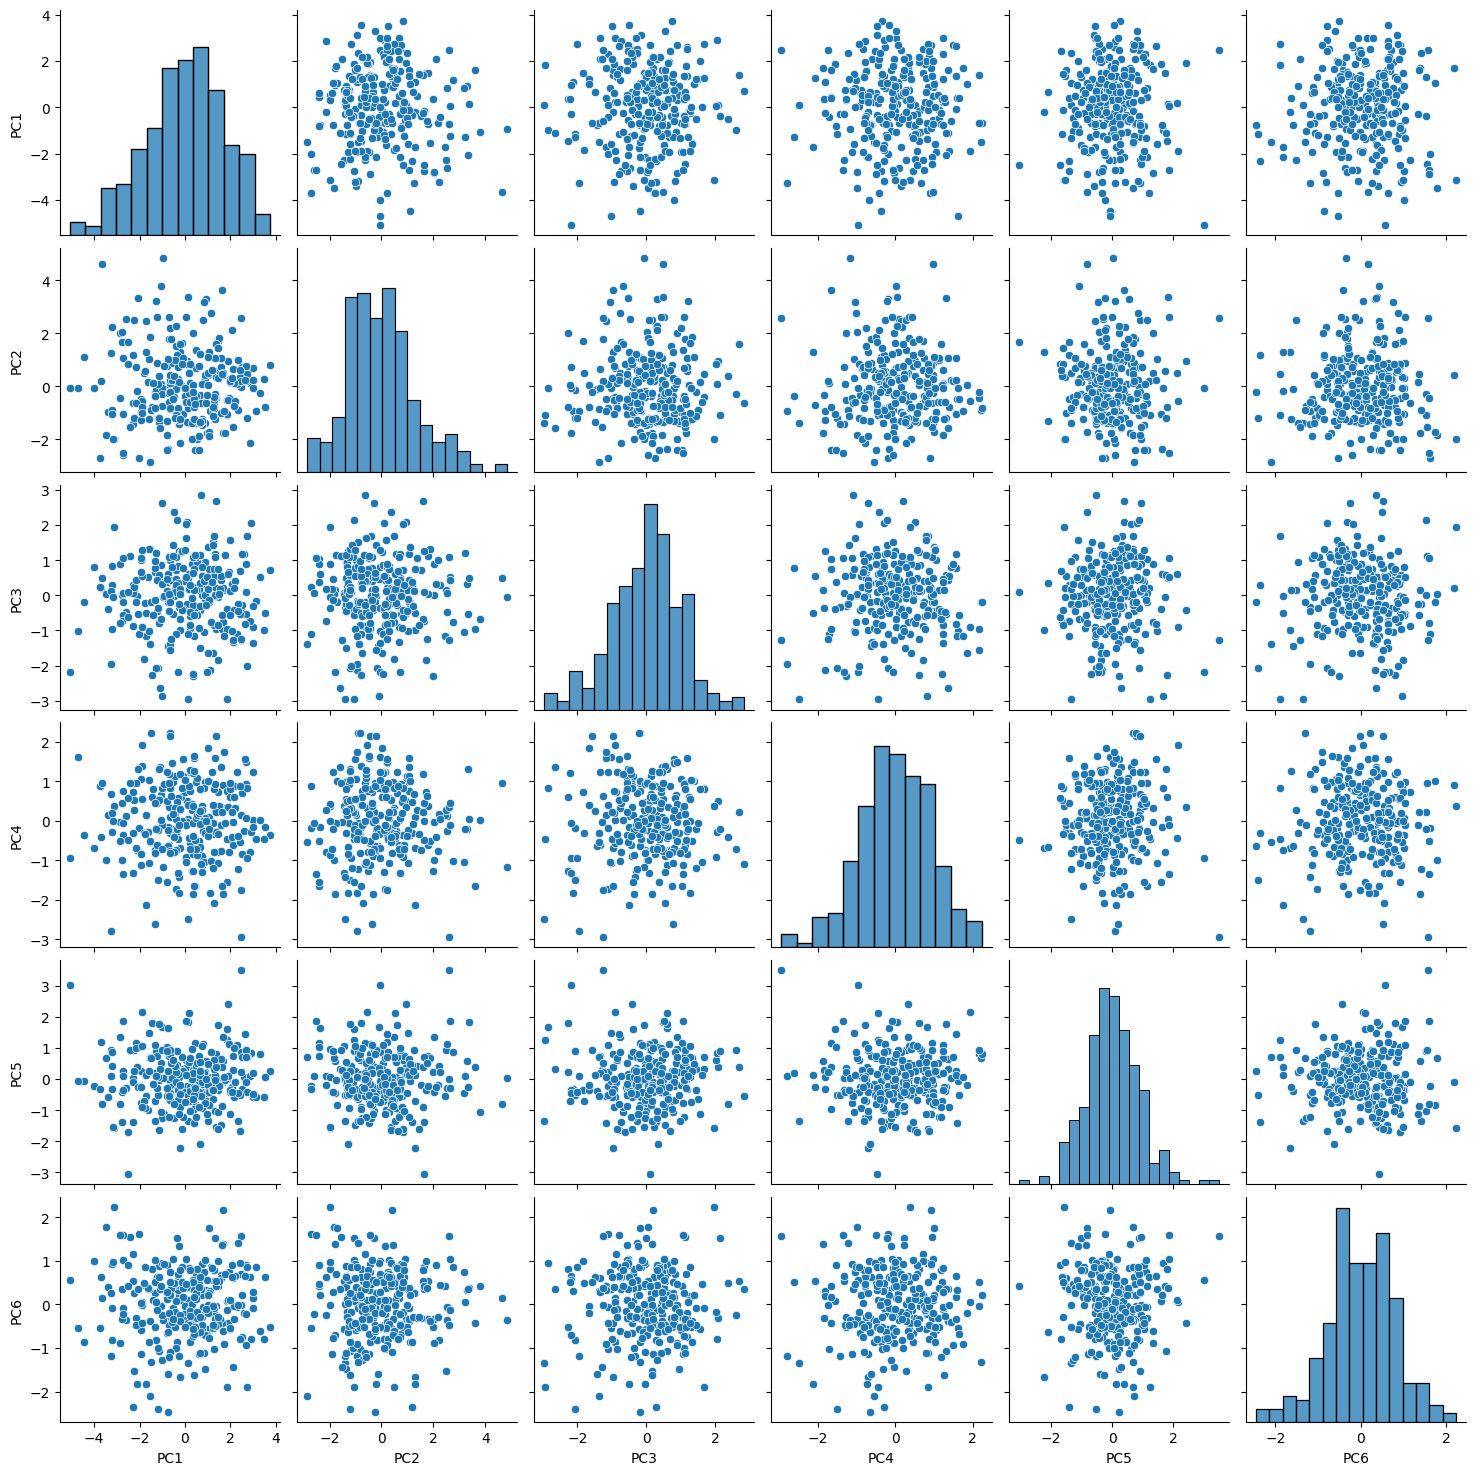

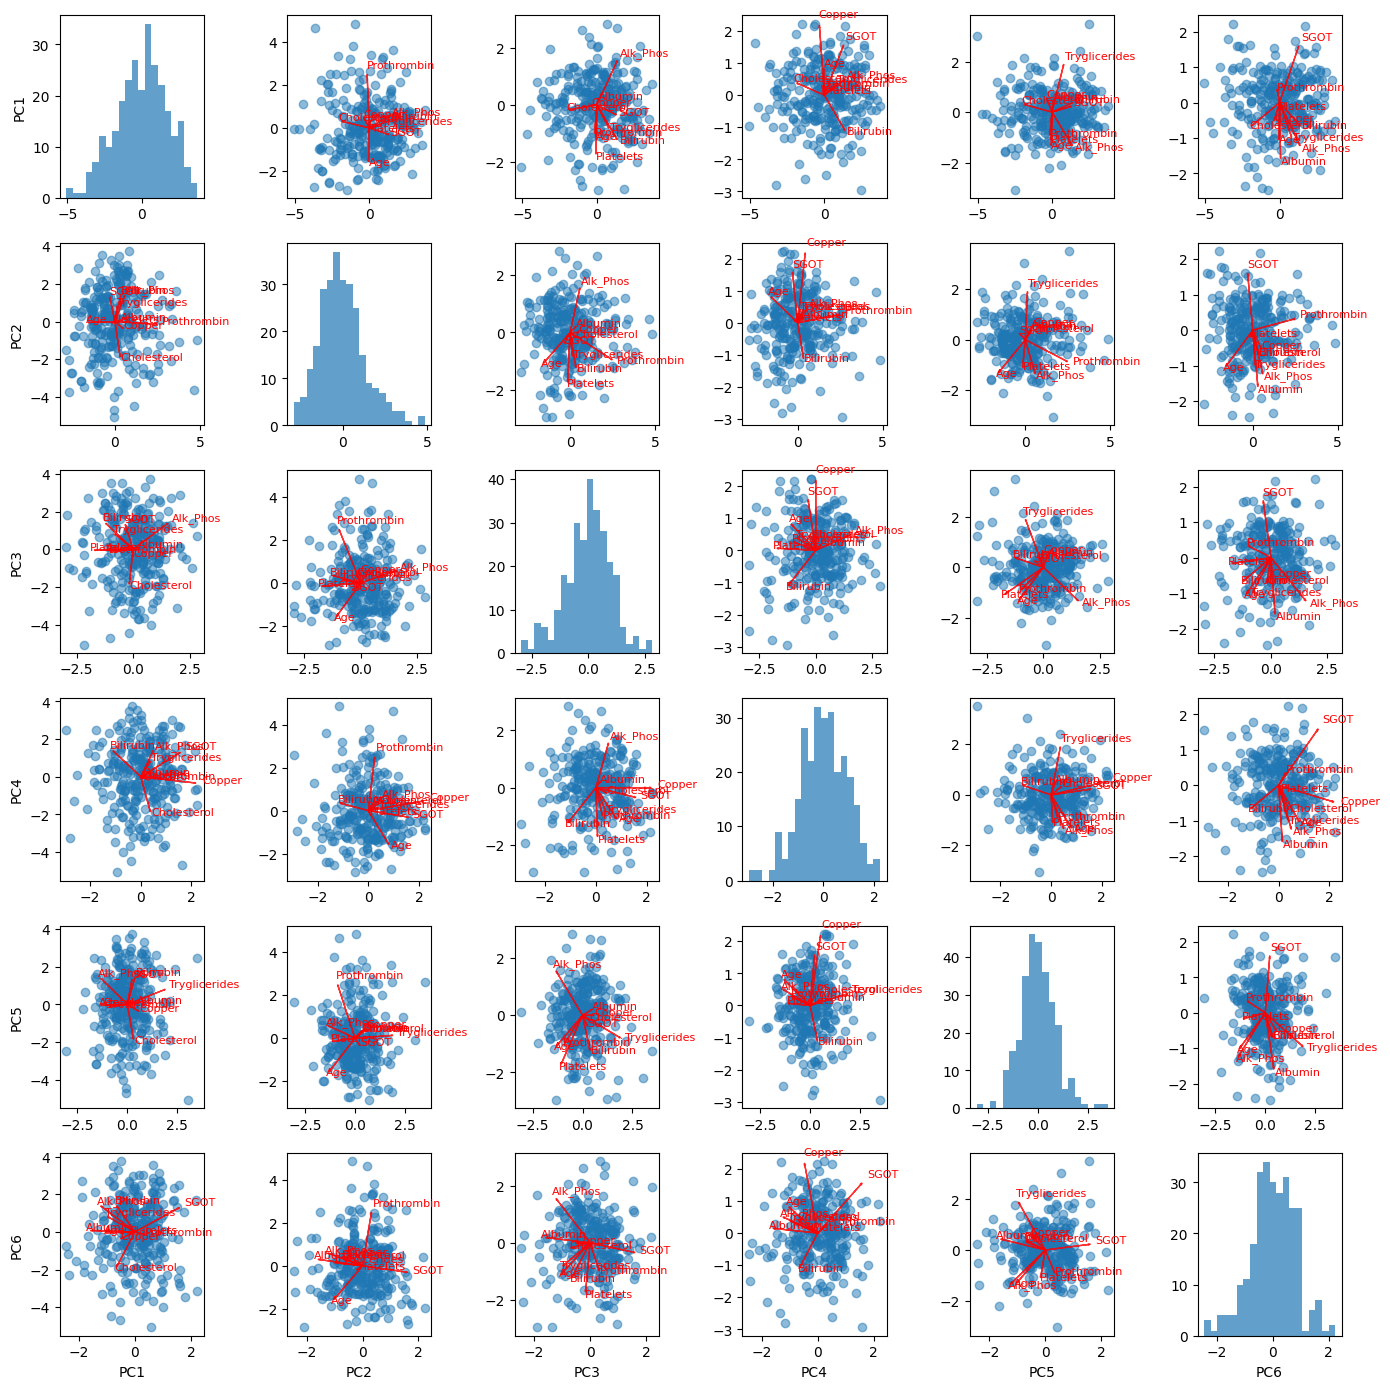

In [16]:

# Assuming `Z` is NxM where N is number of samples and M is number of PCs
df = pd.DataFrame(Z, columns=[f'PC{i+1}' for i in range(Z.shape[1])])

# Plot pairplot for the first 6 components
sns.pairplot(df.iloc[:, :6], diag_kind='hist')


fig, axes = plt.subplots(6, 6, figsize=(14, 14))

# Set scale factor for the vectors to appear clearer
scale_factor = 3

# Loop through all pairs of PCs to generate subplots
for i in range(6):  # For each PC on the X-axis
    for j in range(6):  # For each PC on the Y-axis
        if i == j:
            axes[i, j].hist(Z[:, i], bins=20, alpha=0.7)
        else:
            axes[i, j].scatter(Z[:, i], Z[:, j], alpha=0.5)

            # Plot variable directions (loading vectors) for the PC pair (i,j)
            for var in range(V.shape[0]):
                axes[i, j].arrow(0, 0, V[i, var] * scale_factor, V[j, var] * scale_factor,
                                 color='red', alpha=0.8, head_width=0.05)
                axes[i, j].text(V[i, var] * scale_factor * 1.15, V[j, var] * scale_factor * 1.15, 
                                f'{data.columns[var]}', color='red', fontsize=8)

        if i == 5:
            axes[i, j].set_xlabel(f'PC{j+1}')
        if j == 0:
            axes[i, j].set_ylabel(f'PC{i+1}')

plt.tight_layout()
#plt.savefig('scatter_matrix.svg')
plt.show()


Same plot as before but with the data points marked with color by the classification class.

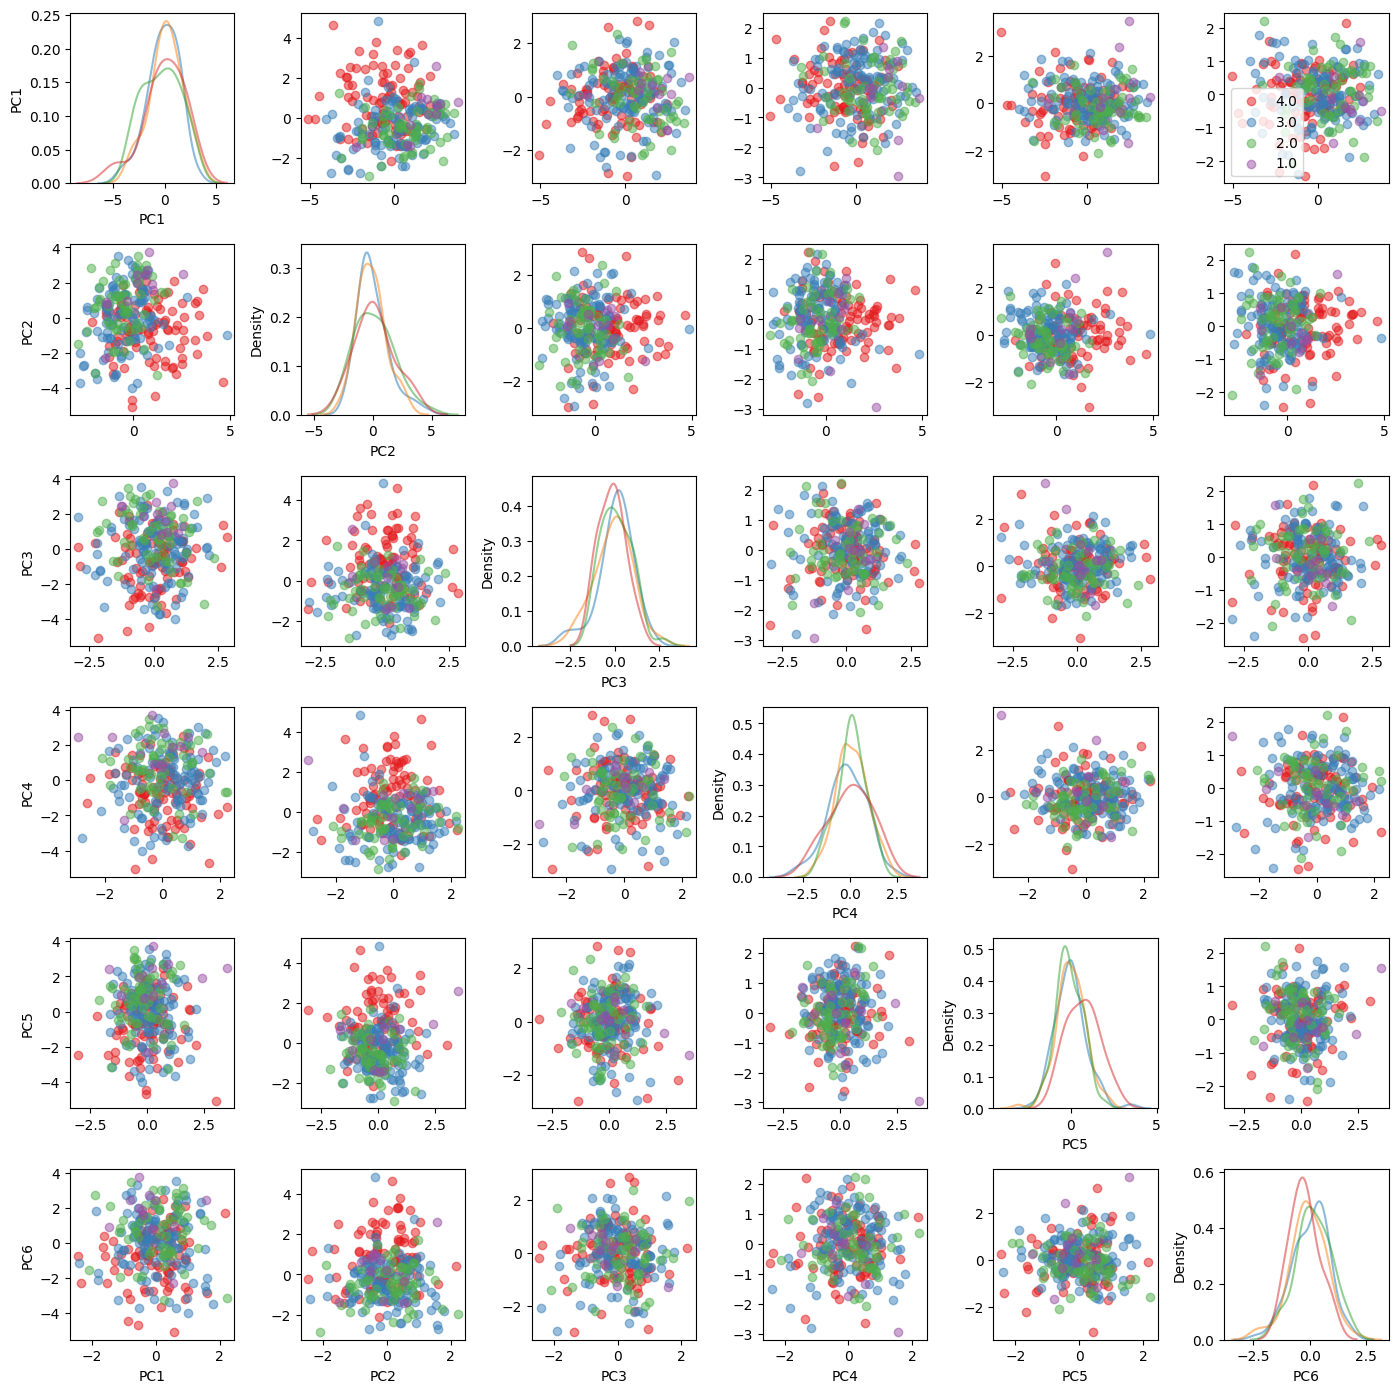

In [18]:
# Create a grid for PCA pair plots with arrows for variable loadings
fig, axes = plt.subplots(6, 6, figsize=(14, 14))

df['Stage'] = data['Stage']

# Set scale factor for the vectors to appear clearer
scale_factor = 3

# Color palette for classes
class_palette = sns.color_palette("Set1", len(data['Stage'].unique()))

# Loop through all pairs of PCs to generate subplots
for i in range(6):  # For each PC on the X-axis
    for j in range(6):  # For each PC on the Y-axis
        if i == j:
            for stage in data['Stage'].unique():
                sns.kdeplot(df[df['Stage'] == stage].iloc[:, i], ax=axes[i,j], label=stage, alpha=0.5)
        else:
            for stage in data['Stage'].unique():
                class_mask = data['Stage'] == stage
                axes[i, j].scatter(Z[class_mask, i], Z[class_mask, j], alpha=0.5,
                                   color=class_palette[data['Stage'].unique().tolist().index(stage)], label=stage)

        if i == 5:
            axes[i, j].set_xlabel(f'PC{j+1}')
        if j == 0:
            axes[i, j].set_ylabel(f'PC{i+1}')

# Add legend for class labels
axes[0, 5].legend(loc='best')

plt.tight_layout()
#plt.savefig('scatter_matrix_with_classes.svg')
plt.show()